# Load Data

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
combine = [train_df, test_df]
# combine is used to ensure whatever preprocessing is done on training data
# is also done on test data

# NOTE! When we change train_df or test_df the objects in combine 
# will also change (combine is only a pointer to the objects)

In [3]:
# Plot styling and display options
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

# Explore Data

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


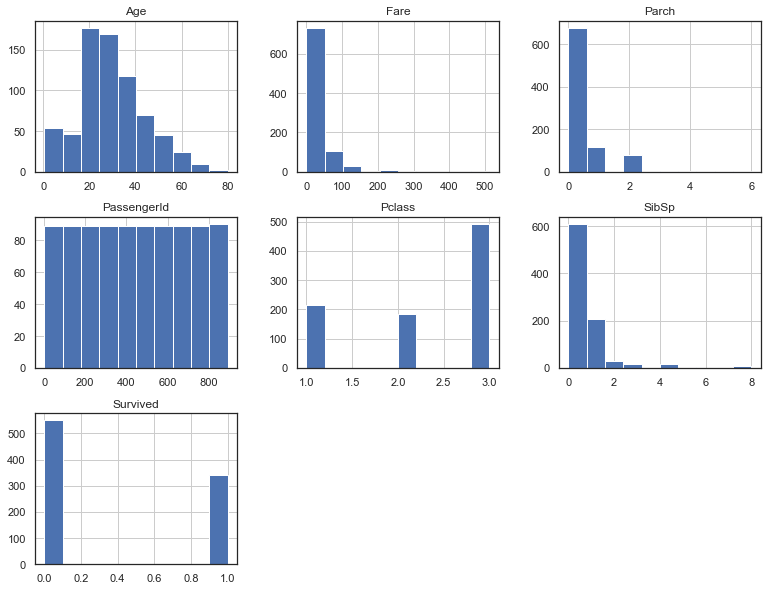

In [5]:
train_df.hist(figsize=(13,10))
plt.show()

In [6]:
target_count = train_df['Survived'].value_counts()
target_count

0    549
1    342
Name: Survived, dtype: int64

In [7]:
target_count[0]/(sum(target_count)) 

0.6161616161616161

In [8]:
print("Shapes Before: (train) (test) = ", \
      train_df.shape, test_df.shape)

Shapes Before: (train) (test) =  (891, 12) (418, 11)


In [9]:
# Drop columns 'Ticket', 'Cabin', need to do it for both test and training

train_df = train_df.drop(['PassengerId','Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("Shapes After: (train) (test) =", train_df.shape, test_df.shape)

Shapes After: (train) (test) = (891, 9) (418, 9)


In [10]:
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


# Feature Engineering

In [11]:
# List example titles in Name column

train_df.Name[:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [12]:
# from the Name column we will extract title of each passenger
# and save that in a column in the dataset called 'Title'
# if you want to match Titles or Names with any other expression
# refer to this tutorial on regex in python:
# https://www.tutorialspoint.com/python/python_reg_expressions.htm

# Create column called Title

for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [13]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [14]:
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [15]:
# We see common titles like Miss, Mrs, Mr, Master are dominant, we will
# correct some Titles to standard forms and replace the rarest titles 
# with single name 'Rare'

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') #Mademoiselle
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') #Madame

In [16]:
train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


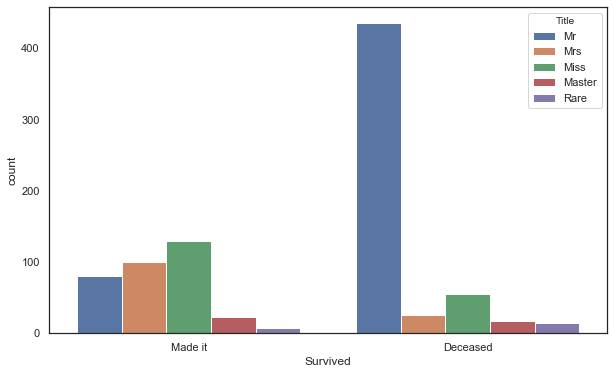

In [17]:
sns.countplot(x='Survived', hue="Title", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it','Deceased']);

make titles into dummies

In [18]:
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

     Master  Miss  Mr  Mrs  Rare
0         0     0   1    0     0
1         0     0   0    1     0
2         0     1   0    0     0
3         0     0   0    1     0
4         0     0   1    0     0
..      ...   ...  ..  ...   ...
886       0     0   0    0     1
887       0     1   0    0     0
888       0     1   0    0     0
889       0     0   1    0     0
890       0     0   1    0     0

[891 rows x 5 columns]
     Master  Miss  Mr  Mrs  Rare
0         0     0   1    0     0
1         0     0   0    1     0
2         0     0   1    0     0
3         0     0   1    0     0
4         0     0   0    1     0
..      ...   ...  ..  ...   ...
413       0     0   1    0     0
414       0     0   0    0     1
415       0     0   1    0     0
416       0     0   1    0     0
417       1     0   0    0     0

[418 rows x 5 columns]


In [19]:
# Title dummy mapping: Map titles to binary dummy columns

for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    print(type(binary_encoded))
    newcols = binary_encoded.columns
    print(newcols)
    dataset[newcols] = binary_encoded

<class 'pandas.core.frame.DataFrame'>
Index(['Master', 'Miss', 'Mr', 'Mrs', 'Rare'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['Master', 'Miss', 'Mr', 'Mrs', 'Rare'], dtype='object')


In [20]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].replace(["male","female"], [0,1])

In [21]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,Mr,0,0,1,0,0


In [22]:
# create empty array  for later use

guess_ages = np.zeros((2,3),dtype=int) 
guess_ages

array([[0, 0, 0],
       [0, 0, 0]])

In [23]:
# Fill the NA's for the Age columns
# with "qualified guesses"

for idx,dataset in enumerate(combine):  
    # method adds a counter to an iterable and returns it in a form of enumerate object.     
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(0, 2):
        for j in range(0,3):
            print((dataset['Sex'] == i)&(dataset['Pclass'] == j+1))
            guess_df = dataset[(dataset['Sex'] == i)&(dataset['Pclass'] == j+1)]['Age'].dropna()
            print(guess_df)

            # Extract the median age for this group
            # (less sensitive) to outliers
            age_guess = guess_df.median()
          
            # Convert random age float to int
            guess_ages[i,j] = int(age_guess)
    
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
                    & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    

    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done! \n\n\n')
train_df.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889     True
890    False
Length: 891, dtype: bool
6      54.0
23     28.0
27     19.0
30     40.0
34     28.0
       ... 
822    38.0
857    51.0
867    31.0
872    33.0
889    26.0
Name: Age, Length: 101, dtype: float64
0      False
1      False
2      False
3      False
4      False
       ...  
886     True
887    False
888    False
889    False
890    False
Length: 891, dtype: bool
20     35.0
21     34.0
33     66.0
70     32.0
72     21.0
       ... 
848    28.0
861    21.0
864    24.0
883    28.0
886    27.0
Name: Age, Length: 99, dtype: float64
0       True
1      False
2      False
3      False
4       True
       ...  
886    False
887    False
888    False
889    False
890     True
Length: 891, dtype: bool
0      22.0
4      35.0
7       2.0
12     20.0
13     39.0
 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S,Mr,0,0,1,0,0


In [24]:
# Age bands
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### Distribution of suvival relative to age

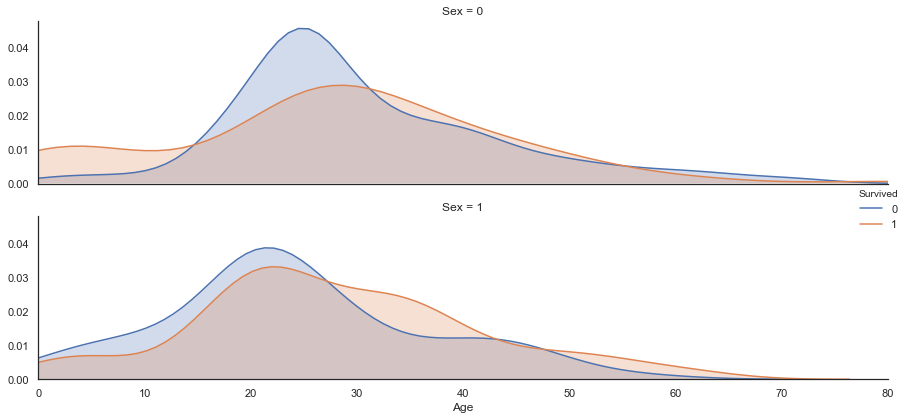

In [25]:
# Plot distributions of Age of passangers who survived 
# or did not survive

plot_distribution( train_df , var = 'Age' , target = 'Survived' ,\
                  row = 'Sex' )

# Recall: {'male': 0, 'female': 1}

In [26]:
# Change Age column to map Age ranges (AgeBands) to integer values of categorical type 

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']=4
train_df.head()

# Note we could just run 
# dataset['Age'] = pd.cut(dataset['Age'], 5,labels=[0,1,2,3,4])

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare,AgeBand
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,7.2500,S,Mr,0,0,1,0,0,"(16.0, 32.0]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,71.2833,C,Mrs,0,0,0,1,0,"(32.0, 48.0]"
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,7.9250,S,Miss,0,1,0,0,0,"(16.0, 32.0]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,53.1000,S,Mrs,0,0,0,1,0,"(32.0, 48.0]"
4,0,3,"Allen, Mr. William Henry",0,2,0,0,8.0500,S,Mr,0,0,1,0,0,"(32.0, 48.0]"


In [27]:
# remove AgeBand column

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,2,0,0,8.0500,S,Mr,0,0,1,0,0


### Travel Party Size

How did the number of people the person traveled with impact the chance of survival?

In [28]:
# SibSp = Number of Sibling / Spouses
# Parch = Parents / Children

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    
# Survival chance against FamilySize

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True) \
                                .mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


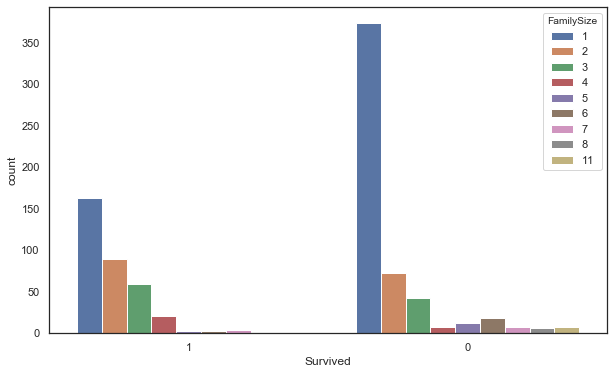

In [29]:
# Plot it, 1 is survived

sns.countplot(x='Survived', hue="FamilySize", data=train_df, order=[1,0]);

In [30]:
# Create binary variable if the person was alone or not

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=True).mean()

,Survived
IsAlone,
0,0.505650
1,0.303538


In [31]:
# We will only use the binary IsAlone feature for further analysis

for df in combine:
    df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1, inplace=True)



# Feature construction

In [32]:
# We can also create new features based on intuitive combinations
# Here is an example when we say that the age times socioclass is a determinant factor

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head()

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3


In [33]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=True).mean()

,Survived
Age*Class,
0,0.550000
1,0.728814
2,0.520408
3,0.277487
4,0.415094
6,0.149425
8,0.000000
9,0.111111
12,0.000000


## Port the person embarked from
Let's see how that influences chance of survival

In [34]:
# To replace Nan value in 'Embarked', we will use the mode
# in 'Embaraked'. This will give us the most frequent port 
# the passengers embarked from
freq_port = train_df['Embarked'].dropna().mode()[0]
print('Most frequent port of Embarkation:',freq_port)


Most frequent port of Embarkation: S


In [35]:
train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=True).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [36]:
for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].fillna(freq_port)
    
train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=True).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


### Survival relative to port of origin

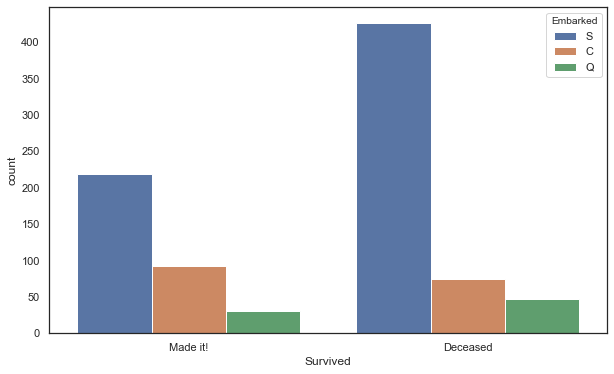

In [37]:
# Plot of relationship between survival and origin 

sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it!', 'Deceased']);


In [38]:
for dataset in combine:
    dummies = pd.get_dummies(dataset["Embarked"])
    columns = dummies.columns
    dataset[columns] = dummies
    dataset.drop('Embarked', axis=1, inplace=True)

train_df.head()
    


,Survived,Pclass,Name,Sex,Age,Fare,Title,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,"Braund, Mr. Owen Harris",0,1,7.2500,Mr,0,0,1,0,0,0,3,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,71.2833,Mrs,0,0,0,1,0,0,2,1,0,0
2,1,3,"Heikkinen, Miss. Laina",1,1,7.9250,Miss,0,1,0,0,0,1,3,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,53.1000,Mrs,0,0,0,1,0,0,2,0,0,1
4,0,3,"Allen, Mr. William Henry",0,2,8.0500,Mr,0,0,1,0,0,1,6,0,0,1


### Fare Amount
What is the relationship between _Fare_ and survival

In [39]:
# Fill the NA values in the Fares column with the median

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,Fare,Title,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,"Kelly, Mr. James",0,2,7.8292,Mr,0,0,1,0,0,1,6,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,7.0000,Mrs,0,0,0,1,0,0,6,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,3,9.6875,Mr,0,0,1,0,0,1,6,0,1,0
3,895,3,"Wirz, Mr. Albert",0,1,8.6625,Mr,0,0,1,0,0,1,3,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,12.2875,Mrs,0,0,0,1,0,0,3,0,0,1


In [40]:
# q cut will find ranges equal to the quartile of the data

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [41]:
for dataset in combine:
    dataset['Fare'] = pd.qcut(train_df['Fare'],4,labels=np.arange(4))
    dataset['Fare'] = dataset['Fare'].astype(int)
    dataset = dataset.drop(['Title',"Name"], axis=1, inplace=True)
    

train_df[['Fare','FareBand']].head()

,Fare,FareBand
0,0,"(-0.001, 7.91]"
1,3,"(31.0, 512.329]"
2,1,"(7.91, 14.454]"
3,3,"(31.0, 512.329]"
4,1,"(7.91, 14.454]"


In [42]:
# Drop FareBand

train_df = train_df.drop(['FareBand'], axis=1) 
combine = [train_df, test_df]

In [43]:
# All features are approximately on the same scale
# no need for feature engineering / normalization

train_df.head(7)

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,0,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,3,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,1,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,3,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,1,0,0,1,0,0,1,6,0,0,1
5,0,3,0,1,1,0,0,1,0,0,1,3,0,1,0
6,0,1,0,3,3,0,0,1,0,0,1,3,0,0,1


In [44]:
test_df.head(7)

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,2,0,0,0,1,0,0,1,6,0,1,0
1,893,3,1,2,3,0,0,0,1,0,0,6,0,0,1
2,894,2,0,3,1,0,0,1,0,0,1,6,0,1,0
3,895,3,0,1,3,0,0,1,0,0,1,3,0,0,1
4,896,3,1,1,1,0,0,0,1,0,0,3,0,0,1
5,897,3,0,0,1,0,0,1,0,0,1,0,0,0,1
6,898,3,1,1,3,0,1,0,0,0,1,3,0,1,0


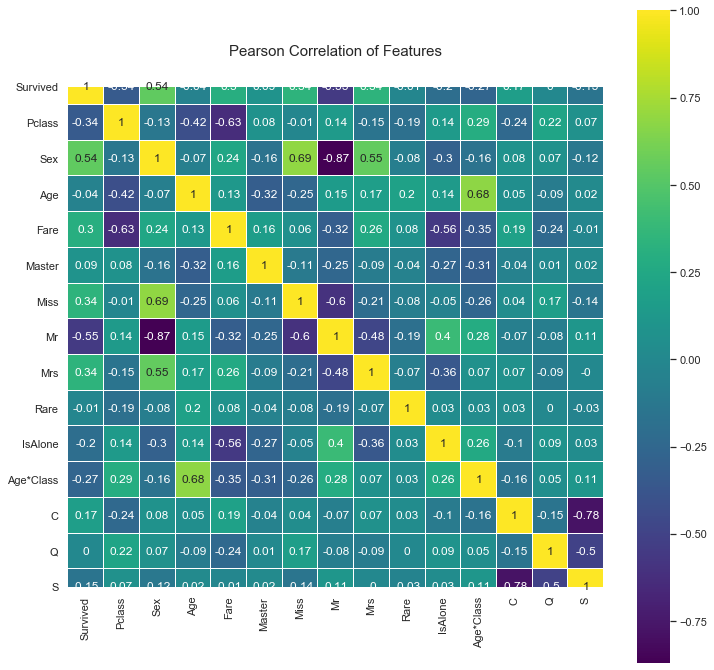

In [45]:
# Uncorrelated features are generally more powerful predictors

## SUREMENT A CHANGER CF AURELIEN JE SAIS PAS QUOI

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

<a id='sec5'></a>
___
## Part 4: Machine Learning!
Now we will Model, Predict, and Choose from algorithms for classification. 
We will try using different classifiers to model and predict. 

We ultimately will choose the best model from:
1. Logistic Regression
2. K-Nearest Neighbors (KNN) 
3. Support Vector Machines (SVM)
4. Perceptron
5. XGBoost
6. Random Forest

In [46]:
X = train_df.drop("Survived", axis=1) # Training & Validation data
Y = train_df["Survived"]              # Response / Target Variable

X_submission  = test_df.drop("PassengerId", axis=1).copy()

print(X.shape, Y.shape)

(891, 14) (891,)


In [47]:
# Split training set so that we validate on 20% of the data
# Note that our algorithms will never have seen the validation 
# data during training. This is to evaluate how good our estimators are.

np.random.seed(1337) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(712, 14) (712,)
(179, 14) (179,)


___
> ### Scikit-Learn general ML workflow
> 1. __Instantiate__ model object
> 2. __Fit__ model to training data
> 3. __Predict & Evaluate__ predict output for data not used during training and compare predicitons against true output values to form an accuracy measure.

___

### Comparing Modeling Approaches (Algorithms)

#### 1. Logistic Regression

In [48]:
X_train.head()

,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
647,1,0,3,3,0,0,0,0,1,1,3,1,0,0
848,2,0,1,3,0,0,0,0,1,0,2,0,0,1
398,2,0,1,1,0,0,0,0,1,1,2,0,0,1
787,3,0,0,2,1,0,0,0,0,0,0,0,1,0
226,2,0,1,1,0,0,1,0,0,1,2,0,0,1


In [49]:
logreg = LogisticRegression()                                # instantiate
logreg.fit(X_train, Y_train)                                 # fit
Y_pred = logreg.predict(X_val)                               # predict
acc_logreg = sum(Y_pred == Y_val)/len(Y_val)*100                # evaluate

print('Logistic Regression labeling accuracy:', str(round(acc_logreg,2)),'%')

Logistic Regression labeling accuracy: 78.21 %


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [50]:
# we could also use scikit learn's method score
# that predicts and then compares to validation set labels
acc_log_2 = logreg.score(X_val, Y_val)                       # evaluate

print('Logistic Regression using built-in method:', str(round(acc_log_2*100,2)),'%')

Logistic Regression using built-in method: 78.21 %


#### 2. KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors = 3)                  # instantiate
knn.fit(X_train, Y_train)                                    # fit
acc_knn = knn.score(X_val, Y_val)                            # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_knn*100,2)),'%')            

K-Nearest Neighbors labeling accuracy: 79.33 %


#### 3. SVM

In [52]:
# Support Vector Machines Classifier (non-linear kernel)
svc = SVC()                                                  # instantiate
svc.fit(X_train, Y_train)                                    # fit
acc_svc = svc.score(X_val, Y_val)                            # predict + evaluate

print('Support Vector Machines labeling accuracy:', str(round(acc_svc*100,2)),'%')

Support Vector Machines labeling accuracy: 84.36 %


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### 4. Perceptron

In [53]:
perceptron = Perceptron()                                    # instantiate 
perceptron.fit(X_train, Y_train)                             # fit
acc_perceptron = perceptron.score(X_val, Y_val)              # predict + evalaute

print('Perceptron labeling accuracy:', str(round(acc_perceptron*100,2)),'%')

Perceptron labeling accuracy: 81.01 %


#### 5. XGBoost

In [54]:
# XGBoost, same API as scikit-learn
gradboost = xgb.XGBClassifier(n_estimators=1000)             # instantiate
gradboost.fit(X_train, Y_train)                              # fit
acc_xgboost = gradboost.score(X_val, Y_val)                  # predict + evalute

print('XGBoost labeling accuracy:', str(round(acc_xgboost*100,2)),'%')

XGBoost labeling accuracy: 83.8 %


#### 6. Random Forest

In [55]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=500)   # instantiate
random_forest.fit(X_train, Y_train)                         # fit
acc_rf = random_forest.score(X_val, Y_val)                  # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_rf*100,2)),'%')

K-Nearest Neighbors labeling accuracy: 82.68 %


#### 7. Decision Tree

In [60]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
# Y_pred = decision_tree.predict(X_test)
print(round(decision_tree.score(X_train, Y_train) * 100, 2))


87.08


### Neural Network

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(units=300, activation='relu', input_shape=(14,) ))
model.add( Dense(units=100, activation='relu'))
model.add( Dense(units=50, activation='relu'))
model.add( Dense(units=1, activation='sigmoid') )

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train.values, Y_train.values, epochs = 50, batch_size= 50)

# # Evaluate the model Accuracy on test set
print('Neural Network accuracy:',str(round(model.evaluate(X_val.values, Y_val.values, batch_size=50,verbose=False)[1]*100,2)),'%')

ModuleNotFoundError: No module named 'tensorflow'

### Importance scores in the random forest model

Training accuracy Random Forest: 0.8707865168539326


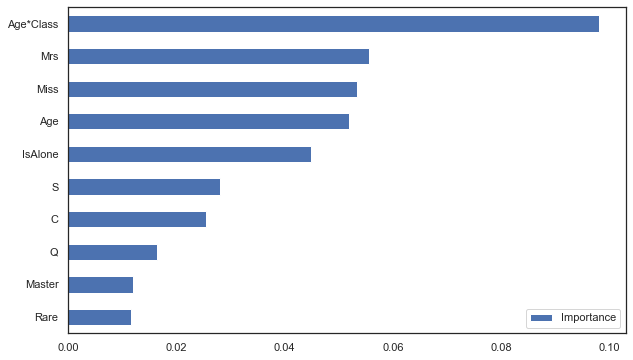

In [58]:
# Look at importnace of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('Training accuracy Random Forest:',model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)

# compete

In [61]:
# How to create a Kaggle submission with a Random Forest Classifier
Y_submission = random_forest.predict(X_submission)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_submission
    })
submission.to_csv('titanic.csv', index=False)